In [1]:
import torch
import torchaudio
import torchaudio.functional as AF
import math
import logging

import matplotlib.pyplot as plt

In [55]:
plt.rcParams['font.sans-serif'] = 'SimHei'  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

音频采样率为: 44100次/秒
波形采样次数为: 23445,持续时间为0.532s


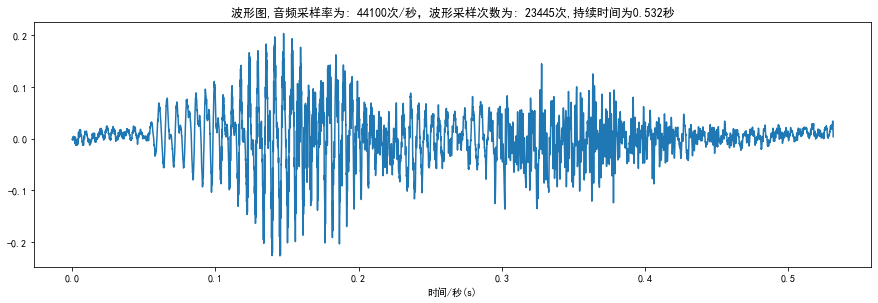

In [64]:
wav_file = 'F:/test/recordAudio/nihao.wav'
# wav_file = 'F:/test/ASRT_v1.2.0/output.wav'
signal, samplerate = torchaudio.load(wav_file)
signal = signal[0]
def wav_show(signal, sr=None):
    if sr:
        print("音频采样率为: {}次/秒".format(sr))
    print("波形采样次数为: {},持续时间为{:.3f}s".format(len(signal),len(signal)/sr))
    plt.figure(figsize=(15, 4.5))
    plt.xlabel("时间/秒(s)")
    # plt.ylabel('yyyyyyyyyyy')
    time = [float(x/sr)  for x in range(0,len(signal))]
    plt.plot(time,signal)
    plt.title('波形图,音频采样率为: {}次/秒，波形采样次数为: {}次,持续时间为{:.3f}秒'.format(sr,len(signal),len(signal)/sr))
    plt.show()

def frame_show(t):
    print("Shape of spectrogram: {}".format(t.size()))
    plt.figure(figsize=(15, 4.5))
    plt.imshow(t.abs().numpy(), cmap='gray')
    plt.colorbar()
    plt.show()
wav_show(signal, samplerate)


In [18]:
time_aa

NameError: name 'time_aa' is not defined

In [4]:
numcep = 13
nfilt = 26
nfft = 512
winlen = 0.025
hoplen = 0.01

In [5]:
def preemphasis(signal, preemph=0.97):
    """
    Pre-emphasis on the input signal
    :param signal: (time,)
    :param preemph:
    :return: (time,)
    """
    return torch.cat((signal[0:1], signal[1:] - preemph * signal[:-1]))

Shape of waveform: torch.Size([738390])
Sample rate of waveform: 16000


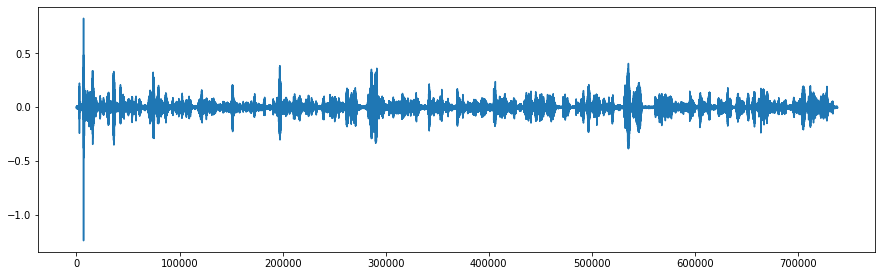

In [6]:
signal = preemphasis(signal, preemph=0.97)
wav_show(signal, samplerate)

In [7]:
def framesig(signal, framelen, framehop, winfunc=lambda x: torch.ones((x,))):
    """
    Frame a signal into overlapping frames.
    :param signal: (time,)
    :param framelen:
    :param framehop:
    :param winfunc:
    :return: (nframes, framelen)
    """
    slen = len(signal)
    framelen = round(framelen)  # round_half_up(framelen)
    framehop = round(framehop)  # round_half_up(framehop)
    if slen <= framelen:
        nframes = 1
    else:
        nframes = 1 + int(math.ceil((1.0 * slen - framelen) / framehop)) 

    padlen = int((nframes - 1) * framehop + framelen)

    zeros = torch.zeros((padlen - slen,))
    padsignal = torch.cat((signal, zeros))

    indices = torch.arange(0, framelen).view((1, -1)) \
              + torch.arange(0, nframes * framehop, framehop).view((-1, 1))
    frames = padsignal[indices]
    win = winfunc(framelen).view((1, -1))
    return frames * win

The length of a frame: 400, the length of a hop: 160
Shape of spectrogram: torch.Size([400, 4614])


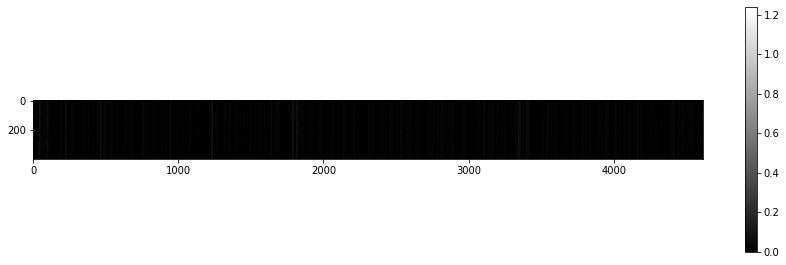

In [8]:
frames = framesig(signal, winlen*samplerate, hoplen*samplerate)
print('The length of a frame: {}, the length of a hop: {}'.format(round(winlen*samplerate), 
                                                                  round(hoplen*samplerate)))
frame_show(frames.t())

In [9]:
def magspec(frames, nfft):
    """
    Compute the magnitude spectrum of each frame.
    The result of `torch.rfft` is separate pairs of real and complex.
    :param frames: (nframes, framelen)
    :param nfft:
    :return: (nframes, nfft//2+1)
    """
    if frames.shape[1] > nfft:
        logging.warning(
            'frame length (%d) is greater than FFT size (%d), frame will be truncated. Increase NFFT to avoid.',
            frames.shape[1], nfft)
        frames = frames[:, :nfft]
    else:
        frames = torch.cat((frames, torch.zeros((frames.shape[0], nfft - frames.shape[1]))), 1)
    complex_spec = torch.rfft(frames, 1)
    return torch.norm(complex_spec, dim=2)


def powspec(frames, nfft):
    """
    Compute the power spectrum of each frame.
    :param frames: (nframes, framelen)
    :param nfft:
    :return: (nframes, nfft//2+1)
    """
    return 1.0 / nfft * (magspec(frames, nfft) ** 2)

In [10]:
pspec = powspec(frames, nfft)
frame_show(pspec.log().t())

AttributeError: module 'torch' has no attribute 'rfft'

In [11]:
def get_energy(psepc):
    energy = torch.sum(pspec, 1)
    energy[energy == 0] = 2.220446049250313e-16
    return energy

In [12]:
energy = get_energy(pspec)
wav_show(energy.log())

NameError: name 'pspec' is not defined